In [1]:
import pandas as pd
import numpy as np
import math
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

In [2]:
base_dir = "Data/"

label2one = {'B':0,'S':1,'X':2}
one2label = {0:'B', 1:'S', 2:'X'}

def normalize(data):
    mu = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return mu, std, (data-mu)/std

vfunc = np.vectorize(lambda x:label2one[x])

input_labels = ['pitcher','batter','balls', 'strikes','inning','pitch_count',
                'x0','x','y','ax','ay','az','px','pz','sz_top','sz_bot',
             'vx0','vy0','vz0','pfx_x','z0','start_speed','end_speed',
             'break_y','break_angle','break_length','spin_dir','spin_rate',
             ]
#feature_length = len(input_labels)-2
#print("Feature length:{}".format(feature_length))
train_years = [4,5,6]
dev_years = [7]


train_x = {}
train_y = {}
ctr = 0
for y in train_years:
    filename= base_dir+"MLB_201{0}/MLB_PitchFX_201{0}_RegularSeason.csv".format(str(y))
    print("Loading {}".format(filename))
    f = pd.read_csv(filename)
    
    tmp_x = f[input_labels]
    tmp_y = f['umpcall']

    tmp_x = tmp_x.as_matrix()
    tmp_y = tmp_y.as_matrix()
    tmp_y = vfunc(tmp_y)

    if ctr==0:
        ctr=1
        train_x = tmp_x
        train_y = tmp_y
    else:
        print(train_x.shape)
        print(tmp_x.shape)
        train_x = np.concatenate((train_x, tmp_x), axis=0)
        train_y = np.concatenate((train_y, tmp_y), axis=0)
    
    filename= base_dir+"MLB_201{0}/MLB_PitchFX_201{0}_PostSeason.csv".format(str(y))
    print("Loading {}".format(filename))
    f = pd.read_csv(filename)
    
    tmp_x = f[input_labels]
    tmp_y = f['umpcall']

    tmp_x = tmp_x.as_matrix()
    tmp_y = tmp_y.as_matrix()
    tmp_y = vfunc(tmp_y)
    if ctr==0:
        ctr=1
        train_x = tmp_x
        train_y = tmp_y
    else:
        print(train_x.shape)
        print(tmp_x.shape)
        train_x = np.concatenate((train_x, tmp_x), axis=0)
        train_y = np.concatenate((train_y, tmp_y), axis=0)

filename = base_dir+"MLB_2017/MLB_PitchFX_2017_RegularSeason.csv"
print("Loading test file {}".format(filename))
f2 = pd.read_csv(filename)
test_x = f2[input_labels]
test_y = f2['umpcall']

test_x = test_x.as_matrix()
test_y = test_y.as_matrix()
test_y = vfunc(test_y)

filename = base_dir+"MLB_2017/MLB_PitchFX_2017_PostSeason.csv"
print("Loading test file {}".format(filename))
f2 = pd.read_csv(filename)

tmp_x = f2[input_labels]
tmp_y = f2['umpcall']

tmp_x = tmp_x.as_matrix()
tmp_y = tmp_y.as_matrix()
tmp_y = vfunc(tmp_y)

test_x = np.concatenate((test_x, tmp_x), axis=0)
test_y = np.concatenate((test_y, tmp_y), axis=0)

Loading Data/MLB_2014/MLB_PitchFX_2014_RegularSeason.csv
Loading Data/MLB_2014/MLB_PitchFX_2014_PostSeason.csv
(658428, 28)
(8837, 28)
Loading Data/MLB_2015/MLB_PitchFX_2015_RegularSeason.csv
(667265, 28)
(672271, 28)
Loading Data/MLB_2015/MLB_PitchFX_2015_PostSeason.csv
(1339536, 28)
(10277, 28)
Loading Data/MLB_2016/MLB_PitchFX_2016_RegularSeason.csv
(1349813, 28)
(703809, 28)
Loading Data/MLB_2016/MLB_PitchFX_2016_PostSeason.csv
(2053622, 28)
(10076, 28)
Loading test file Data/MLB_2017/MLB_PitchFX_2017_RegularSeason.csv
Loading test file Data/MLB_2017/MLB_PitchFX_2017_PostSeason.csv


In [3]:
vv = np.vectorize(lambda x: (isinstance(x, float) and math.isnan(x) ))
idx = ~np.logical_or(vv(train_x[:,0]), vv(train_x[:,1]))
train_x = train_x[idx]
train_y = train_y[idx]

In [4]:
from sklearn.model_selection import train_test_split
train_x, dev_x, train_y, dev_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0, shuffle=True)

In [5]:
train_x[0,:]

array(['conlead01', 'duvalad01', 0, 1, 4, 56, 2.823, 163.08, 188.78,
       14.453, 27.369, -16.593, -1.209, 1.8519999999999999, 3.52, 1.67,
       -13.081, -128.709, -7.119, 8.64, 5.945, 88.3, 81.1, 23.8, -33.1,
       5.2, 137.15200000000002, 2395.51], dtype=object)

In [6]:
class Lang:
    def __init__(self, name):
        """Init Lang with a name."""
        self.name = name
        self.word2index = {"<UNK>": 0}
        self.word2count = {}
        self.index2word = {0: "<UNK>"}
        self.n_words = 1  # Count SOS and EOS

    def addword(self, word):
        """Add a word to the dict."""
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [77]:
def map2idx(train_x, pl, bl):
    pi = train_x[:,0]
    vfnc = np.vectorize(lambda x: pl.word2index[x] if x in pitch_lang.word2index else 0)
    pi = vfnc(pi).reshape(-1,1)
    vfnc = np.vectorize(lambda x:bl.word2index[x] if x in batter_lang.word2index else 0)
    ba = vfnc(train_x[:,1]).reshape(-1,1)
    
    return np.concatenate((pi,ba,train_x[:,2:]), axis=1)

def data_gen(dx, df, dff, dy, batch_size=100):
    idx = 0
    while True:
        if idx*batch_size >= dx.shape[0]:
            return
        elif (idx+1)*batch_size > dx.shape[0]:
            yield dx[idx*batch_size:,:], df[idx*batch_size:,:], dff[idx*batch_size:,:], dy[idx*batch_size:]
        else:
            yield dx[idx*batch_size:(idx+1)*batch_size,:], df[idx*batch_size:(idx+1)*batch_size], dff[idx*batch_size:(idx+1)*batch_size], dy[idx*batch_size:(idx+1)*batch_size]
        idx += 1

def train(train_x, train_f, train_ff, train_y, dev_x, dev_f, dev_ff, dev_y, model, model2, scheduler, optimizer, criterion, batch_size=512, max_epoch = 512, validation_interv=1000):
    for ep in range(max_epoch):
        scheduler.step()
        print("Epoch {}".format(ep))
        train_iter = data_gen(train_x, train_f, train_ff, train_y, batch_size=batch_size)
        ctr = 0
        avg_loss = 0
        for bx,bf,bff,by in train_iter:
            optimizer.zero_grad()
            model.train()
            y_pred = model(bx,bf, bff)
            loss = criterion(y_pred, by)
            loss.backward()
            avg_loss += loss.item()*bx.shape[0]
            optimizer.step()
            ctr+= bx.shape[0]*2
        #dy_pred = model(dev_x, dev_f)
        model.eval()
        ll = 0
        ctrr = 0
        acc = 0
        for dx,df,dff,dy in data_gen(dev_x, dev_f, dev_ff, dev_y, batch_size=batch_size):
            dy_pred = model(dx, df, dff)
            tmp = criterion(dy_pred, dy).item()
            ll += tmp * dx.shape[0]
            ctrr += dx.shape[0]
            mv, mi = torch.max(dy_pred, 1)
            acc += torch.sum( mi == dy ).item()
        
        print("loss:{} dev_loss:{}, dev_acc:{}".format(avg_loss/ctr, ll/ctrr, acc / ctrr))

def train2(train_x, train_f, train_ff, train_y, dev_x, dev_f, dev_ff, dev_y, model, model2, scheduler, optimizer, criterion, batch_size=512, max_epoch = 512, validation_interv=1000):
    for ep in range(max_epoch):
        scheduler.step()
        print("Epoch {}".format(ep))
        train_iter = data_gen(train_x, train_f, train_ff, train_y, batch_size=batch_size)
        ctr = 0
        avg_loss = 0
        for bx,bf,bff,by in train_iter:
            optimizer.zero_grad()
            model.train()
            model2.train()
            y_pred = model(bx,bf, bff)
            y_pred2 = model2(bx,bf, bff)
            loss = criterion(y_pred, by)
            loss2 = criterion(y_pred2, by)
            loss.backward()
            loss2.backward()
            avg_loss += loss.item()*bx.shape[0]
            avg_loss += loss2.item()*bx.shape[0]
            optimizer.step()
            ctr+= bx.shape[0]*2
        #dy_pred = model(dev_x, dev_f)
        model.eval()
        ll = 0
        ctrr = 0
        acc = 0
        for dx,df,dff,dy in data_gen(dev_x, dev_f, dev_ff, dev_y, batch_size=batch_size):
            dy_pred = model2(dx, df, dff)
            tmp = criterion(dy_pred, dy).item()
            ll += tmp * dx.shape[0]
            ctrr += dx.shape[0]
            mv, mi = torch.max(dy_pred, 1)
            acc += torch.sum( mi == dy ).item()
        
        print("loss:{} dev_loss:{}, dev_acc:{}".format(avg_loss/ctr, ll/ctrr, acc / ctrr))


In [33]:
pitch_lang = Lang('pitcher')
batter_lang = Lang('batter')
player_lang = Lang('player')
pits = train_x[:,0]
bats = train_x[:,1]
for i in range(len(train_x)):
    pitch_lang.addword(pits[i])
    batter_lang.addword(bats[i])
    player_lang.addword(pits[i])    
    player_lang.addword(bats[i])

In [24]:
DEVICE = torch.device('cuda')

In [30]:
train_x.shape

(1857328, 28)

In [26]:
vtx = Variable(torch.from_numpy(map2idx(train_x[:,:2], pitch_lang, batter_lang).astype(np.long))).to(DEVICE)
vtf = Variable(torch.from_numpy(train_x[:,2:6].astype(np.long))).to(DEVICE)
vtff = Variable(torch.from_numpy(train_x[:,6:].astype(np.float32))).to(DEVICE)
vty = Variable(torch.from_numpy(train_y)).to(DEVICE)

vdx = Variable(torch.from_numpy(map2idx(dev_x[:,:2], pitch_lang, batter_lang).astype(np.long))).to(DEVICE)
vdf = Variable(torch.from_numpy(dev_x[:,2:6].astype(np.long))).to(DEVICE)
vdff = Variable(torch.from_numpy(dev_x[:,6:].astype(np.float32))).to(DEVICE)
vdy = Variable(torch.from_numpy(dev_y)).to(DEVICE)

vtestx = Variable(torch.from_numpy(map2idx(test_x[:,:2], pitch_lang, batter_lang).astype(np.long))).to(DEVICE)
vtestf = Variable(torch.from_numpy(test_x[:,2:6].astype(np.long))).to(DEVICE)
vtestff = Variable(torch.from_numpy(test_x[:,6:].astype(np.float32))).to(DEVICE)
vtesty = Variable(torch.from_numpy(test_y)).to(DEVICE)


# Model 2

In [78]:
class PlayerEmbedding(nn.Module):
    """The class for embedding records.
    This class is for embedding the docvec (r.t, r.e, r.m)
    into a high dimension space.
    Attributes:
        embedding1: embedding for r.t
        embedding2: embedding for r.e
        linear: A linear layer mapping [r.t, r.e, r.m] back to one space
    """

    def __init__(self, pitcher_size, batter_size, embedding_dim):
        super(PlayerEmbedding, self).__init__()
        self.embedding1 = nn.Embedding(pitcher_size, embedding_dim)
        self.embedding2 = nn.Embedding(batter_size, embedding_dim)
        self.emb_balls = nn.Embedding(10 , 2)
        self.emb_strikes = nn.Embedding(10 , 2)
        self.emb_inning = nn.Embedding(20 , 2)
        self.emb_pitctr = nn.Embedding(500 , 2)
        self.embedding_dim = 2*embedding_dim + 8

    def forward(self, p, b, features):
        emb_p = self.embedding1(p)
        emb_b = self.embedding2(b)
        eb_ball = self.emb_balls(features[:,0])
        eb_st = self.emb_strikes(features[:,1])
        eb_inning = self.emb_inning(features[:,2])
        eb_pit = self.emb_pitctr(features[:,3])
        emb_all = torch.cat([emb_p, emb_b, eb_ball, eb_st, eb_inning, eb_pit], dim=1)

        return emb_all

    def init_weights(self):
        initrange = 0.1
        em_layer = [self.embedding1, self.embedding2]

        for layer in em_layer:
            layer.weight.data.normal_(0, initrange)

class Fcc(nn.Module):
    def __init__(self, embedding_layer, post=False):
        super(Fcc, self).__init__()
        self.post = post
        p=0.1
        self.embedding = embedding_layer
        self.drop_emb = nn.Dropout(p)
        self.drop1 = nn.Dropout(p)
        self.drop2 = nn.Dropout(p)
        self.drop3 = nn.Dropout(p)
        self.drop4 = nn.Dropout(p)
        if self.post:
            self.lin1 = nn.Linear(self.embedding.embedding_dim + 22, 100)
        else:
            self.lin1 = nn.Linear(2*self.embedding.embedding_dim, 100)
        self.act1 = nn.SELU()
        self.lin2 = nn.Linear(100, 100)
        self.act2 = nn.SELU()
        self.lin3 = nn.Linear(100, 100)
        
        self.act3 = nn.SELU()
        self.lin4 = nn.Linear(100, 100)
        self.act4 = nn.SELU()
        self.lin5 = nn.Linear(100, 3)
        
        
        #self.lin4 = nn.Linear(100, 3)

    def forward(self, players, features, ff2):
        embedded = self.embedding(players[:,0], players[:,1], features)
        output = self.drop_emb(embedded)
        
        if self.post:
            output = torch.cat([output, ff2],1)
        output = self.lin1(output)
        output = self.act1(output)
        output = self.drop1(output)
        
        output = self.lin2(output)
        output = self.act2(output)
        output = self.drop2(output)
        
        output = self.lin3(output)
        output = self.act3(output)
        output = self.drop3(output)
        
        output = self.lin4(output)
        output = self.act4(output)
        output = self.drop4(output)
        
        output = self.lin5(output)
        
        output = F.log_softmax(output, dim=1)
        return output

In [79]:
emb_layer = PlayerEmbedding(pitch_lang.n_words,batter_lang.n_words, 5).to(DEVICE)
model = Fcc(emb_layer, post=True).to(DEVICE)
model2 = Fcc(emb_layer, post=False).to(DEVICE)

In [80]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
max_epoch = 100
#opt = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max_epoch, eta_min=0)
crit = nn.NLLLoss()
train(vtx, vtf, vtff, vty, vdx, vdf, vdff, vdy, model, model2, sched, opt, crit, max_epoch=max_epoch, batch_size=4096*16)

Epoch 0
loss:1.1354333831066072 dev_loss:1.06039177376719, dev_acc:0.45990696322139846
Epoch 1
loss:0.5758103937649763 dev_loss:1.0400478960498796, dev_acc:0.45989242622474197
Epoch 2
loss:0.544365268639617 dev_loss:1.0356894361838216, dev_acc:0.4633716140911954
Epoch 3
loss:0.5329353425674541 dev_loss:1.0245571588576865, dev_acc:0.4714929495566216
Epoch 4
loss:0.5179775190575416 dev_loss:0.9459121656711292, dev_acc:0.5542472258564713
Epoch 5
loss:0.4882691692995014 dev_loss:0.8882635430765862, dev_acc:0.6019285748897611
Epoch 6
loss:0.46794398912342544 dev_loss:0.8743912439894618, dev_acc:0.6083975384018995
Epoch 7
loss:0.45537811547239737 dev_loss:0.8518571959641944, dev_acc:0.6188738673256772
Epoch 8
loss:0.4425206908232713 dev_loss:0.8240352926544483, dev_acc:0.6321655279352619
Epoch 9
loss:0.43082639676414064 dev_loss:0.8042414583328962, dev_acc:0.643572224645055
Epoch 10
loss:0.4219707724621539 dev_loss:0.7938865279835972, dev_acc:0.6479381693075544
Epoch 11
loss:0.41548205167652

loss:0.3445362017121791 dev_loss:0.6720188750409454, dev_acc:0.688922808547754
Epoch 93
loss:0.3445285980733466 dev_loss:0.6720040077674918, dev_acc:0.6887677472500848
Epoch 94
loss:0.34467078560016845 dev_loss:0.6722189369096297, dev_acc:0.6888791975577846
Epoch 95
loss:0.344375767262845 dev_loss:0.672168054835778, dev_acc:0.6888452778989194
Epoch 96
loss:0.34445095866728326 dev_loss:0.6721529601710523, dev_acc:0.6887774385811891
Epoch 97
loss:0.34445949025554123 dev_loss:0.6720560999291404, dev_acc:0.6889034258855454
Epoch 98
loss:0.34454790614215125 dev_loss:0.6720367159562477, dev_acc:0.6888695062266802
Epoch 99
loss:0.34448526340807295 dev_loss:0.672014313086224, dev_acc:0.6888888888888889


In [82]:
train(vtx, vtf, vtff, vty, vdx, vdf, vdff, vdy, model, model2, sched, opt, crit, max_epoch=20, batch_size=4096*16)

Epoch 0
loss:0.34418453802113186 dev_loss:0.6719201831090483, dev_acc:0.6888162039056064
Epoch 1
loss:0.34409694085412146 dev_loss:0.6725650662361966, dev_acc:0.6889421912099627
Epoch 2
loss:0.34398246005295724 dev_loss:0.6724262784437401, dev_acc:0.6885981489557591
Epoch 3
loss:0.3438323352128683 dev_loss:0.6717883374378271, dev_acc:0.6887871299122934
Epoch 4
loss:0.34381740889621715 dev_loss:0.6710516972435984, dev_acc:0.6892329311430925
Epoch 5
loss:0.3438105894872331 dev_loss:0.6692926412787024, dev_acc:0.6897223433638611
Epoch 6
loss:0.3435747018473121 dev_loss:0.6700098345207719, dev_acc:0.6894800600862528
Epoch 7
loss:0.3435902351395296 dev_loss:0.6691069188445854, dev_acc:0.6899646266414692
Epoch 8
loss:0.3435311623939256 dev_loss:0.6704365587716256, dev_acc:0.6890487958521103
Epoch 9
loss:0.3433386050093777 dev_loss:0.6704977272837732, dev_acc:0.6890972525076319
Epoch 10
loss:0.34345480912046966 dev_loss:0.6699945087718682, dev_acc:0.6894655230895964
Epoch 11
loss:0.3430759745

In [51]:
print(model)
train(vtx, vtf, vtff, vty, vdx, vdf, vdff, vdy, model, model2, sched, opt, crit, max_epoch=max_epoch, batch_size=4096*16)

Fcc(
  (embedding): PlayerEmbedding(
    (embedding1): Embedding(1073, 5)
    (embedding2): Embedding(1409, 5)
  )
  (drop_emb): Dropout(p=0.1)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.1)
  (drop3): Dropout(p=0.1)
  (drop4): Dropout(p=0.1)
  (lin1): Linear(in_features=40, out_features=100, bias=True)
  (act1): SELU()
  (lin2): Linear(in_features=100, out_features=100, bias=True)
  (act2): SELU()
  (lin3): Linear(in_features=100, out_features=100, bias=True)
  (act3): SELU()
  (lin4): Linear(in_features=100, out_features=100, bias=True)
  (act4): SELU()
  (lin5): Linear(in_features=100, out_features=3, bias=True)
  (emb_balls): Embedding(10, 2)
  (emb_strikes): Embedding(10, 2)
  (emb_inning): Embedding(20, 2)
  (emb_pitctr): Embedding(500, 2)
)


TypeError: train() missing 1 required positional argument: 'criterion'

In [ ]:
emb_layer = PlayerEmbedding(pitch_lang.n_words,batter_lang.n_words, 5).cuda()
emb_layer.load_state_dict(torch.load('shallow_post.pt.emb'))
model = Fcc(emb_layer).cuda()
model.load_state_dict(torch.load('shallow_post.pt.model'))

In [ ]:
torch.save(model.state_dict(), 'shallow_post.pt.model')
torch.save(emb_layer.state_dict(), 'shallow_post.pt.emb')

In [83]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import pickle
import seaborn as sn
import matplotlib.pyplot as plt

def generate_confusion_matrix(y_test, y_train, file_name = "confusion_matrix.png"):
    ax= plt.subplot()
    cm = confusion_matrix(y_test, y_train)
    df_cm = pd.DataFrame(cm, range(3), range(3))
    sn.set(font_scale=1.2)#for label size
    sn.heatmap(df_cm, annot=True, fmt="d",annot_kws={"size": 14}, cmap="YlGnBu")
#     ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['Ball', 'Strike', 'Hit']) 
    ax.yaxis.set_ticklabels(['Ball', 'Strike', 'Hit'])
    #plt.savefig(file_name)
    plt.show()

### Loss

In [85]:
criter = nn.NLLLoss()
with torch.no_grad():
    ll=0
    ctrr=0
    crit=nn.NLLLoss()
    for dx,df,dff,dy in data_gen(vtestx, vtestf, vtestff, vtesty, batch_size=128):
        model.eval()
        dy_pred = model(dx, df, dff)
        tmp = criter(dy_pred, dy).data[0]
        ll += tmp * dx.shape[0]
        ctrr += dx.shape[0]
    dev_loss = ll.item()/ctrr

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if __name__ == '__main__':


### Accuracy

In [86]:
with torch.no_grad():
    ll=0
    ctrr=0
    pred = []
    prob = []
    for dx,df,dff,dy in data_gen(vtestx, vtestf, vtestff, vtesty, batch_size=128):
        model.eval()
        dy_pred = model(dx, df,dff)
        prob.append(dy_pred.cpu().data)
        _,py = torch.max(dy_pred, 1)
        ll += torch.sum(py==dy)
        pred.append(py.cpu().data)
        ctrr += dx.shape[0]
    dev_acc = ll.item()/ctrr

In [87]:
pred_y = torch.cat(pred).numpy()
prob_y = torch.cat(prob).numpy()

Fcc(
  (embedding): PlayerEmbedding(
    (embedding1): Embedding(1073, 5)
    (embedding2): Embedding(1409, 5)
    (emb_balls): Embedding(10, 2)
    (emb_strikes): Embedding(10, 2)
    (emb_inning): Embedding(20, 2)
    (emb_pitctr): Embedding(500, 2)
  )
  (drop_emb): Dropout(p=0.1)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.1)
  (drop3): Dropout(p=0.1)
  (drop4): Dropout(p=0.1)
  (lin1): Linear(in_features=40, out_features=100, bias=True)
  (act1): SELU()
  (lin2): Linear(in_features=100, out_features=100, bias=True)
  (act2): SELU()
  (lin3): Linear(in_features=100, out_features=100, bias=True)
  (act3): SELU()
  (lin4): Linear(in_features=100, out_features=100, bias=True)
  (act4): SELU()
  (lin5): Linear(in_features=100, out_features=3, bias=True)
)
dev loss: 0.696810071412846 dev_acc: 0.6870920248775386


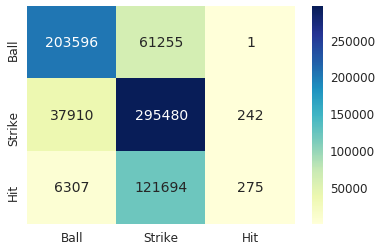

In [89]:
print(model)
print("dev loss: {} dev_acc: {}".format(dev_loss, dev_acc))
generate_confusion_matrix(test_y, pred_y)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
y_test = label_binarize(test_y, classes=[0, 1, 2])
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], prob_y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), prob_y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# Compute macro-average ROC curve and ROC area
lw=2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [ ]:
from sklearn.metrics import f1_score
print("f1_macro: {}, f1_micro: {}".format(f1_score(test_y, pred_y, average='macro'), f1_score(test_y, pred_y, average='micro')))